<a href="https://colab.research.google.com/github/Saba7Allah/Miscellaneous/blob/main/Nasa_Space_Apps_CO2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the following libraries
import requests
import folium
import folium.plugins
from folium import Map, TileLayer
from pystac_client import Client
import branca
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"

# The RASTER API is used to fetch collections for visualization
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# The collection name is used to fetch the dataset from the STAC API. First, we define the collection name as a variable
# Name of the collection for ODIAC dataset
collection_name = "odiac-ffco2-monthgrid-v2023"

In [ ]:
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'requests' library allows a HTTP request possible
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()

# Print the properties of the collection to the console
collection

{'id': 'odiac-ffco2-monthgrid-v2023',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/odiac-ffco2-monthgrid-v2023/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/odiac-ffco2-monthgrid-v2023'}],
 'title': 'ODIAC Fossil Fuel CO₂ Emissions v2023',
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2000-01-01 00:00:00+00',
     '2022-12-31 00:00:00+00']]}},
 'license': 'CC-BY-4.0',
 'renders': {'dashboard': {'assets': ['co2-emissions'],
   'rescale': [[-10, 60]],
   'colormap_name': 'jet'},
  'co2-emissions': {'assets': ['co2-emissions'],
   'rescale': [[-10, 60]],
   'colormap_name': 

In [ ]:
# Create a function that would search for a data collection in the US GHG Center STAC API

# First, we need to define the function
# The name of the function = "get_item_count"
# The argument that will be passed through the defined function = "collection_id"
def get_item_count(collection_id):

    # Set a counter for the number of items existing in the collection
    count = 0

    # Define the path to retrieve the granules (items) of the collection of interest in the STAC API
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"

    # Run a while loop to make HTTP requests until there are no more URLs associated with the collection in the STAC API
    while True:

        # Retrieve information about the granules by sending a "get" request to the STAC API using the defined collection path
        response = requests.get(items_url)

        # If the items do not exist, print an error message and quit the loop
        if not response.ok:
            print("error getting items")
            exit()

        # Return the results of the HTTP response as JSON
        stac = response.json()

        # Increase the "count" by the number of items (granules) returned in the response
        count += int(stac["context"].get("returned", 0))

        # Retrieve information about the next URL associated with the collection in the STAC API (if applicable)
        next = [link for link in stac["links"] if link["rel"] == "next"]

        # Exit the loop if there are no other URLs
        if not next:
            break

        # Ensure the information gathered by other STAC API links associated with the collection are added to the original path
        # "href" is the identifier for each of the tiles stored in the STAC API
        items_url = next[0]["href"]

    # Return the information about the total number of granules found associated with the collection
    return count

In [ ]:
# Apply the function created above "get_item_count" to the data collection
number_of_items = get_item_count(collection_name)

# Get the information about the number of granules found in the collection
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit={number_of_items}").json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 276 items


In [ ]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items[0]

{'id': 'odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_202212',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/odiac-ffco2-monthgrid-v2023'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/odiac-ffco2-monthgrid-v2023'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/odiac-ffco2-monthgrid-v2023/items/odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_202212'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/collections/odiac-ffco2-monthgrid-v2023/items/odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_202212/map?assets=co2-emissions&rescale=-10%2C60&colormap_name=jet',
   'rel': 'previ

In [ ]:
# Now we create a dictionary where the start datetime values for each granule is queried more explicitly by year and month (e.g., 2020-02)
items = {item["properties"]["start_datetime"][:7]: item for item in items}

# Next, we need to specify the asset name for this collection
# The asset name is referring to the raster band containing the pixel values for the parameter of interest
# For the case of the ODIAC Fossil Fuel CO₂ Emissions collection, the parameter of interest is “co2-emissions”
asset_name = "co2-emissions"

In [ ]:
# Fetching the min and max values for a specific item
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

In [ ]:
# Choose a color map for displaying the first observation (event)
# Please refer to matplotlib library if you'd prefer choosing a different color ramp.
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "rainbow"

# Make a GET request to retrieve information for the 2020 tile
# 2020
january_2020_tile = requests.get(

    # Pass the collection name, the item number in the list, and its ID
    f"{RASTER_API_URL}/collections/{items['2020-01']['collection']}/items/{items['2020-01']['id']}/tilejson.json?"

    # Pass the asset name
    f"&assets={asset_name}"

    # Pass the color formula and colormap for custom visualization
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"

    # Pass the minimum and maximum values for rescaling
    f"&rescale={rescale_values['min']},{rescale_values['max']}",

# Return the response in JSON format
).json()

# Print the properties of the retrieved granule to the console
january_2020_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/odiac-ffco2-monthgrid-v2023/items/odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_202001/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=co2-emissions&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=-675.1028442382812%2C31415.447265625'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [ ]:
# Make a GET request to retrieve information for the 2000 tile
# 2000
january_2000_tile = requests.get(

    # Pass the collection name, the item number in the list, and its ID
    f"{RASTER_API_URL}/collections/{items['2000-01']['collection']}/items/{items['2000-01']['id']}/tilejson.json?"

    # Pass the asset name
    f"&assets={asset_name}"

    # Pass the color formula and colormap for custom visualization
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"

    # Pass the minimum and maximum values for rescaling
    f"&rescale={rescale_values['min']},{rescale_values['max']}",

# Return the response in JSON format
).json()

# Print the properties of the retrieved granule to the console
january_2000_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/odiac-ffco2-monthgrid-v2023/items/odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_200001/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=co2-emissions&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=-675.1028442382812%2C31415.447265625'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [ ]:
# To change the location, you can simply insert the latitude and longitude of the area of your interest in the "location=(LAT, LONG)" statement

# Set the initial zoom level and center of map for both tiles
# 'folium.plugins' allows mapping side-by-side
map_ = folium.plugins.DualMap(location=(
        30.091051879776643,31.209326808349243
    ), zoom_start=6)

# Define the first map layer (January 2020)
map_layer_2020 = TileLayer(
    tiles=january_2020_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer
)

# Add the first layer to the Dual Map
map_layer_2020.add_to(map_.m1)

# Define the second map layer (January 2000)
map_layer_2000 = TileLayer(
    tiles=january_2000_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer
)

# Add the second layer to the Dual Map
map_layer_2000.add_to(map_.m2)

# Visualize the Dual Map
map_

A comparison between CO₂ emissions in Egypt in 2020 and 2000.

In [ ]:
# Texas, USA
texas_aoi = {
    "type": "Feature", # Create a feature object
    "properties": {},
    "geometry": { # Set the bounding coordinates for the polygon
        "coordinates": [
            [
                # [13.686159004559698, -21.700046934333145],
                # [13.686159004559698, -23.241974326585833],
                # [14.753560168039911, -23.241974326585833],
                # [14.753560168039911, -21.700046934333145],
                # [13.686159004559698, -21.700046934333145],
                [29.23359585724571, 33.545000244810026], # South-east bounding coordinate
                [31.486868721991264, 33.282867406070224],# North-east bounding coordinate
                [31.604652706985185,28.2754502140282], # North-west bounding coordinate
                [29.78162065323971,28.24184338723597], # South-west bounding coordinate
                [29.23359585724571, 33.545000244810026]  # South-east bounding coordinate (closing the polygon)
            ]
        ],
        "type": "Polygon",
    },
}

In [ ]:
# Create a new map to display the generated polygon
# We'll plug in the coordinates for a location
# central to the study area and a reasonable zoom level
aoi_map = Map(

    # Base map is set to OpenStreetMap
    tiles="OpenStreetMap",

    # Define the spatial properties for the map
    location=[
        30.091051879776643,31.209326808349243
    ],

    # Set the zoom value
    zoom_start=6,
)

# Insert the polygon to the map
folium.GeoJson(texas_aoi, name="Texas, USA").add_to(aoi_map)

# Visualize the map
aoi_map

بلغ إجمالي انبعاثات ثاني أكسيد الكربون في مصر حوالي 290.3 مليون طن في عام 2020، مع العلم أن نسبة كبيرة من هذه الانبعاثات ناتجة عن احتراق الوقود ..
لأحفوري​


In [ ]:
# Check total number of items available within the collection
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=300"
).json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 276 items


In [ ]:
# Examine the first item in the collection
items[0]

{'id': 'odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_202212',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/odiac-ffco2-monthgrid-v2023'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/odiac-ffco2-monthgrid-v2023'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/odiac-ffco2-monthgrid-v2023/items/odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_202212'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/collections/odiac-ffco2-monthgrid-v2023/items/odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_202212/map?assets=co2-emissions&rescale=-10%2C60&colormap_name=jet',
   'rel': 'previ

In [ ]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
# Create a function that retrieves information regarding a specific granule using its asset name and raster identifier and generates the statistics for it

# The function takes an item (granule) and a JSON (polygon) as input parameters
def generate_stats(item, geojson):

    # A POST request is made to submit the data associated with the item of interest (specific observation) within the boundaries of the polygon to compute its statistics
    result = requests.post(

        # Raster API Endpoint for computing statistics
        f"{RASTER_API_URL}/cog/statistics",

        # Pass the URL to the item, asset name, and raster identifier as parameters
        params={"url": item["assets"][asset_name]["href"]},

        # Send the GeoJSON object (polygon) along with the request
        json=geojson,

    # Return the response in JSON format
    ).json()

    # Return a dictionary containing the computed statistics along with the item's datetime information.
    return {
        **result["properties"],
        "start_datetime": item["properties"]["start_datetime"][:7],
    }

In [ ]:
%%time
# %%time = Wall time (execution time) for running the code below

# Generate statistics using the created function "generate_stats" within the bounding box defined by the polygon
# This process may take a few minutes to complete
stats = [generate_stats(item, texas_aoi) for item in items]

CPU times: total: 469 ms
Wall time: 5min 49s


In [ ]:
# Print the stats for the first item in the collection
stats[3]

{'statistics': {'b1': {'min': 1.8306468725204468,
   'max': 101872.734375,
   'mean': 35.68561935424805,
   'count': 18497.009765625,
   'sum': 660077.25,
   'std': 799.5460821616225,
   'median': 20.656192779541016,
   'majority': 2.4826130867004395,
   'minority': 1.8306468725204468,
   'unique': 17320.0,
   'histogram': [[18798.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
    [1.8306468725204468,
     10188.921875,
     20376.01171875,
     30563.103515625,
     40750.1953125,
     50937.28515625,
     61124.37890625,
     71311.4609375,
     81498.5546875,
     91685.6484375,
     101872.734375]],
   'valid_percent': 10.36,
   'masked_pixels': 162745.0,
   'valid_pixels': 18800.0,
   'percentile_2': 2.416374444961548,
   'percentile_98': 106.45987701416016}},
 'start_datetime': '2022-09'}

In [ ]:
# Create a function that converts statistics in JSON format into a pandas DataFrame
def clean_stats(stats_json) -> pd.DataFrame:

    # Normalize the JSON data
    df = pd.json_normalize(stats_json)

    # Replace the naming "statistics.b1" in the columns
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]

    # Set the datetime format
    df["date"] = pd.to_datetime(df["start_datetime"])

    # Return the cleaned format
    return df

# Apply the generated function on the stats data
df = clean_stats(stats)

# Display the stats for the first 5 granules in the collection in the table
# Change the value in the parenthesis to show more or a smaller number of rows in the table
df.head(5)

,start_datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2022-12,1.693515,93024.679688,32.921753,18497.009766,608954.000,730.123063,19.108860,2.296643,1.693515,17320.0,"[[18798.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",10.36,162745.0,18800.0,2.235366,98.485077,2022-12-01
1,2022-11,1.702772,93971.382812,33.134369,18497.009766,612886.750,737.545846,19.213308,2.309196,1.702772,17319.0,"[[18798.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",10.36,162745.0,18800.0,2.247585,99.023392,2022-11-01
2,2022-10,1.823524,101057.851562,35.515579,18497.009766,656932.000,793.157574,20.575817,2.472953,1.823524,17320.0,"[[18798.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",10.36,162745.0,18800.0,2.406972,106.045631,2022-10-01
3,2022-09,1.830647,101872.734375,35.685619,18497.009766,660077.250,799.546082,20.656193,2.482613,1.830647,17320.0,"[[18798.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",10.36,162745.0,18800.0,2.416374,106.459877,2022-09-01
4,2022-08,2.047341,114887.421875,39.980984,18497.009766,739528.625,901.675420,23.101269,2.776480,2.047341,17320.0,"[[18798.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",10.36,162745.0,18800.0,2.702401,119.061539,2022-08-01


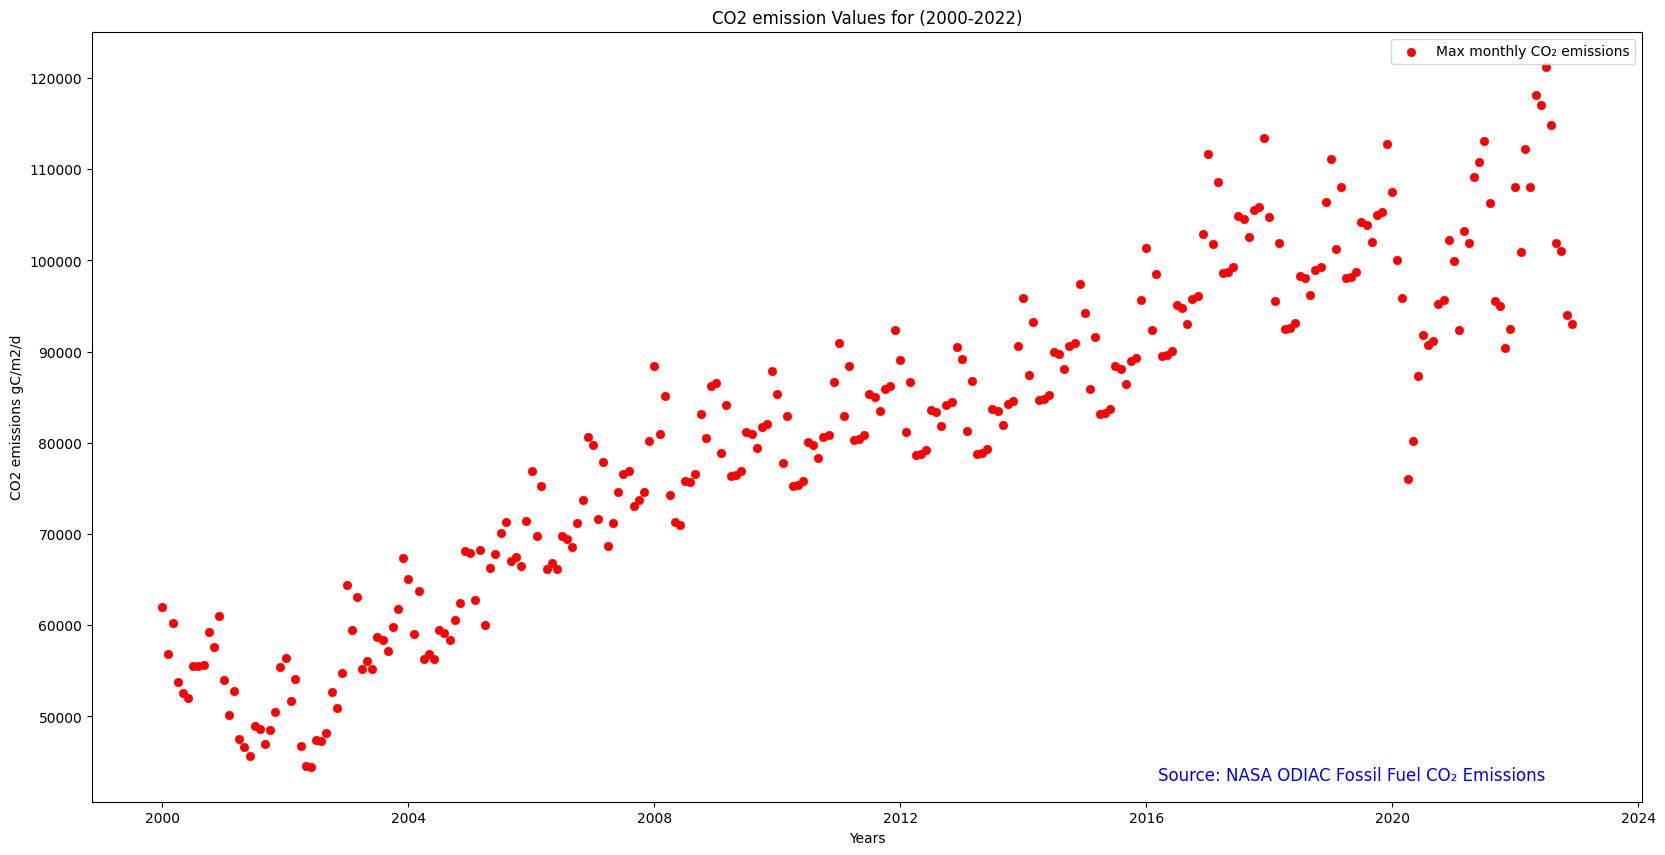

In [ ]:
# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(20, 10))


plt.scatter(
    df["date"], # X-axis: sorted datetime
    df["max"], # Y-axis: maximum CO₂ level
    color="red", # Line color
    linestyle="-", # Line style
    linewidth=0.5, # Line width
    label="Max monthly CO₂ emissions", # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("CO2 emissions gC/m2/d")

# Insert title for the plot
plt.title("CO2 emission Values for (2000-2022)")

###
# Add data citation
plt.text(
    df["date"].iloc[5],           # X-coordinate of the text
    df["max"].min(),              # Y-coordinate of the text




    # Text to be displayed
    "Source: NASA ODIAC Fossil Fuel CO₂ Emissions",
    fontsize=12,                             # Font size
    horizontalalignment="right",             # Horizontal alignment
    verticalalignment="top",                 # Vertical alignment
    color="blue",                            # Text color
)

# Plot the time series
plt.show()

**Scatter represents CO₂ regional emissions from fossil fuel from 2000 to 2022.